# Sentiment Analysis For Reviews on Amazon 

### importing the necessary libraries 

In [1]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from numpy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

## Importing the dataset

In [2]:
df = pd.read_csv('musical_instruments_reviews.csv')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(df.shape))
print (df.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10254 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB
None


In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


# Preprocessing and cleaning

**lots of preprocessing has to be done before sending the reviews to the model. Let's go step by step.**

## Handling NaN values

**checking for null values**

In [4]:
#Creating a copy
process_reviews=df.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

**null values is encountered in the reviewer names and review text. Since reviewer names don’t contribute to the project’s objective (we already have IDs), we can focus on the review text instead. Dropping these null values likely won’t cause any issues since there are only 7, but I’m considering imputing them as "missing" to explore why no review was provided. Could it be influenced by their ratings?**

In [5]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

## Concatenating review text and summary
Let's combine review text and summary column. The sentiments won't be contradicting in nature. 

In [6]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...


In [7]:
process_reviews.shape

(10261, 8)

## Creating 'sentiment' column
**This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative If it is equal to 3, we take that as neutral sentiment**

In [8]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

overall
5    6938
4    2084
3     772
2     250
1     217
Name: count, dtype: int64

In [9]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [10]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"02 28, 2014","Not much to write about here, but it does exac...",Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,"03 16, 2013",The product does exactly as it should and is q...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,"08 28, 2013",The primary job of this device is to block the...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...,Positive


In [11]:
process_reviews['sentiment'].value_counts()

sentiment
Positive    9022
Neutral      772
Negative     467
Name: count, dtype: int64

## Handling time column

**There is an unusual review time column that includes both the date and year. First, we’ll separate these two components, and then further split the date into month and day.**

In [12]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["date"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["year"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,date,year
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"Not much to write about here, but it does exac...",Positive,02 28,2014
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,The product does exactly as it should and is q...,Positive,03 16,2013
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,The primary job of this device is to block the...,Positive,08 28,2013
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,02 14,2014
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,This pop filter is great. It looks and perform...,Positive,02 21,2014


In [13]:
# Splitting the date 
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"Not much to write about here, but it does exac...",Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,The product does exactly as it should and is q...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,The primary job of this device is to block the...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,This pop filter is great. It looks and perform...,Positive,2014,02,21


## Finding the helpfulness of the review
**From the main dataframe we can see the helpful feature with values in list [a,b] format. It says that a out of b people found that review helpful. But with that format, it could not add value to the machine learning model and it will be difficult to decrypt the meaning for the machine. So I have planned to create helpful_rate feature which returns a/b value from [a,b]. The following codeblock contains the complete processing step. I have added comments on what's happenening in each code. Unhide to see the code**

In [14]:
# Splitting the dataset based on comma and square bracket 
new1 = process_reviews["helpful"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)


# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)

In [15]:
process_reviews.head()

,reviewerID,asin,reviewerName,overall,unixReviewTime,reviews,sentiment,year,month,day,helpful_rate
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...",5,1393545600,"Not much to write about here, but it does exac...",Positive,2014,02,28,0.00
1,A14VAT5EAX3D9S,1384719342,Jake,5,1363392000,The product does exactly as it should and is q...,Positive,2013,03,16,0.93
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",5,1377648000,The primary job of this device is to block the...,Positive,2013,08,28,1.00
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",5,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,2014,02,14,0.00
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,5,1392940800,This pop filter is great. It looks and perform...,Positive,2014,02,21,0.00


**The helpful_rate column have successfully been created through the processing steps. Let's look at the values**

In [16]:
process_reviews['helpful_rate'].value_counts()

helpful_rate
0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: count, Length: 65, dtype: int64

**0.00 indicates that the review hasn't been much helpful and 1.00 indicates that the review has been very helpful**

## Review text-Punctuation Cleaning
**Let's begin our text processing by removing the punctuations**

In [17]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [18]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [19]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

,reviewerID,asin,overall,reviews,sentiment,year,month,day,helpful_rate
0,A2IBPI20UZIR0U,1384719342,5,not much to write about here but it does exact...,Positive,2014,02,28,0.00
1,A14VAT5EAX3D9S,1384719342,5,the product does exactly as it should and is q...,Positive,2013,03,16,0.93
2,A195EZSQDW3E21,1384719342,5,the primary job of this device is to block the...,Positive,2013,08,28,1.00
3,A2C00NNG1ZQQG2,1384719342,5,nice windscreen protects my mxl mic and preven...,Positive,2014,02,14,0.00
4,A94QU4C90B1AX,1384719342,5,this pop filter is great it looks and performs...,Positive,2014,02,21,0.00


**all punctuation have been cleared in the review column**

## Review text-Stop words
**Regarding stop words, the general NLTK stop words list includes terms like *not*, *hasn't*, and *wouldn't*, which convey negative sentiment. Removing these words could conflict with the target variable (sentiment). To address this, I’ve curated a custom list of stop words that excludes those with negative sentiment or their alternatives.**

In [20]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [21]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

,reviewerID,asin,overall,reviews,sentiment,year,month,day,helpful_rate
0,A2IBPI20UZIR0U,1384719342,5,not much write but exactly supposed filters po...,Positive,2014,02,28,0.00
1,A14VAT5EAX3D9S,1384719342,5,product exactly quite affordablei not realized...,Positive,2013,03,16,0.93
2,A195EZSQDW3E21,1384719342,5,primary job device block breath would otherwis...,Positive,2013,08,28,1.00
3,A2C00NNG1ZQQG2,1384719342,5,nice windscreen protects mxl mic prevents pops...,Positive,2014,02,14,0.00
4,A94QU4C90B1AX,1384719342,5,pop filter great looks performs like studio fi...,Positive,2014,02,21,0.00


all the stop words have been removed in the review column

<a id="section-three"></a>
# Story Generation and Visualization from reviews
**here, we will do exploratory data analysis on texts as well as other factors to understand what are all features which contributes to the sentiment.**

**Prior analysis assumptions:**
* Higher helpful rate sentiment becomes positive
* There will be many negative sentiment reviews in the 2013 and 2014 year
* There will be more reviews at the starting of a month

**These assumptions will be verified with our plots also we will do text analysis alot.**

## Sentiments vs Helpful rate
**lets check if there is any relationship between sentiment of review and helpfulness of it**

In [22]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

,helpful_rate
sentiment,
Negative,0.307559
Neutral,0.275687
Positive,0.260505


**From the table we can see that the mean of of helpful rate is higher for any negative reviews than neutral and positive reviews. These mean value might have been influenced by the 0 values in helpful rates. Lets check how it is distributed through violin plot**

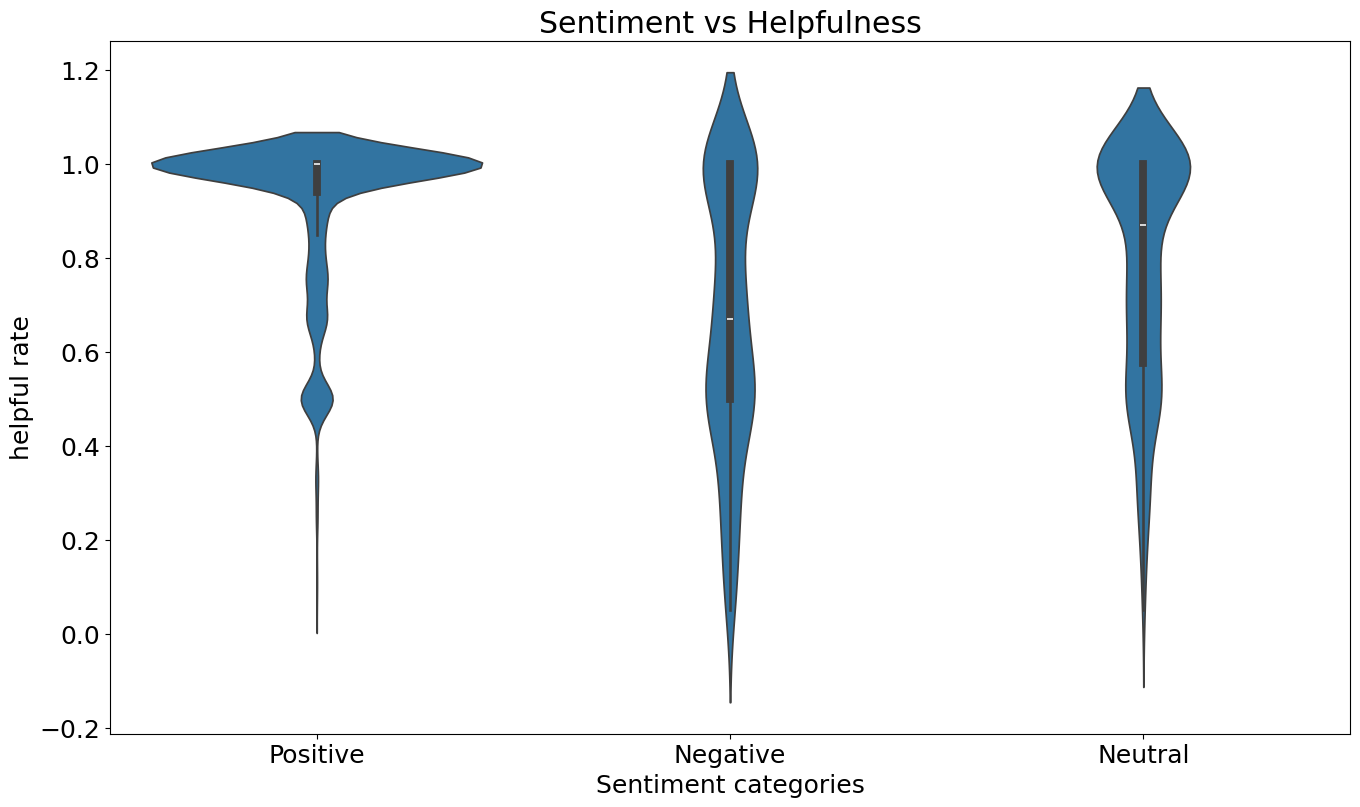

In [23]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

**From the plot we can declare that more number of positive reviews are having high helpful rate. We got deceived by the mean value, it's better to look at a plot rather than taking some measures of central tendency under such situation. Our first assumption is correct !**

## Year vs Sentiment count
**In this block we will see how many reviews were posted based on sentiments in each year from 2004 to 2014**

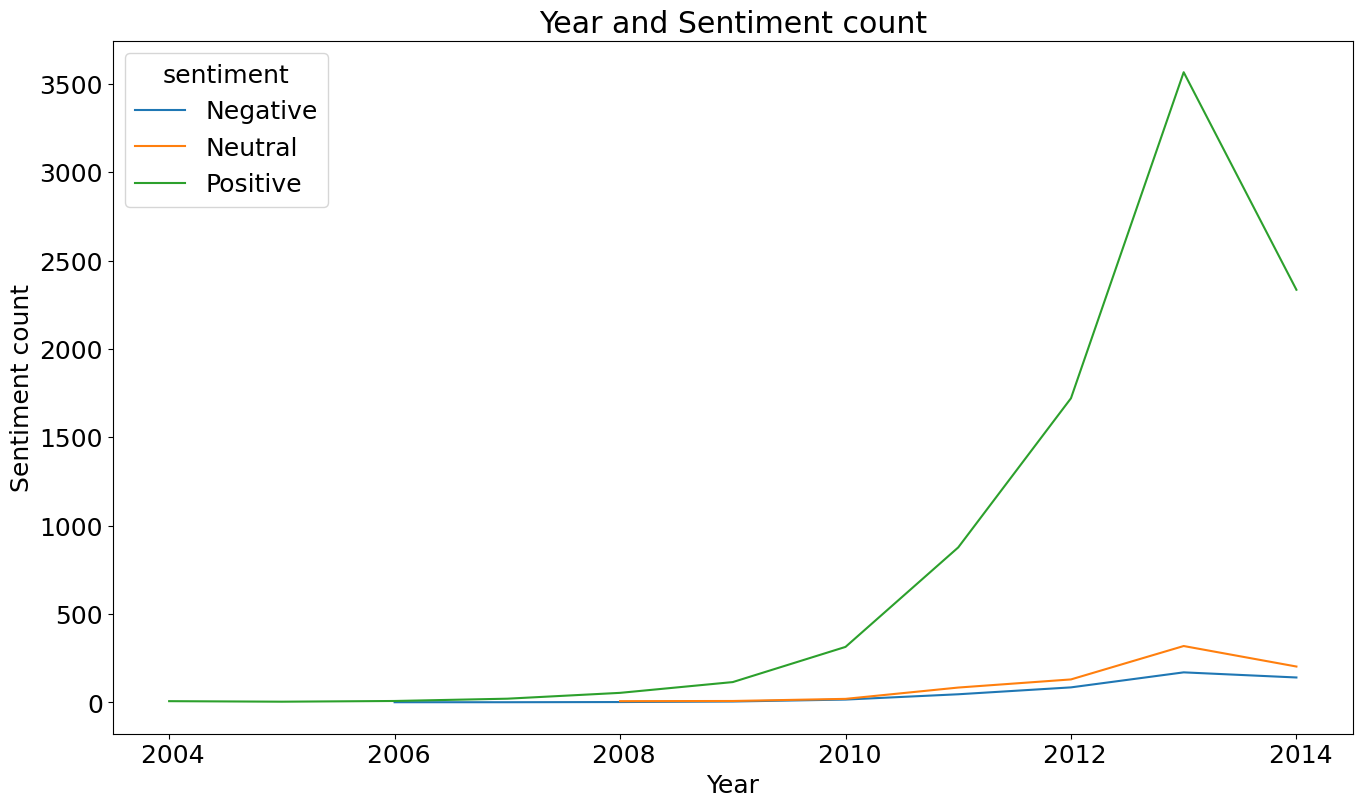

In [24]:
process_reviews.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

**From the plot we can clearly see the rise in positive reviews from 2010. Reaching its peak around 2013 and there is a dip in 2014, All the review rates were dropped at this time. Negative and neutral reviews are very low as compared to the positive reviews. Our second assumption is wrong !**

## Day of month vs Reviews count
**Let's check if there are any relationship between reviews and day of month**

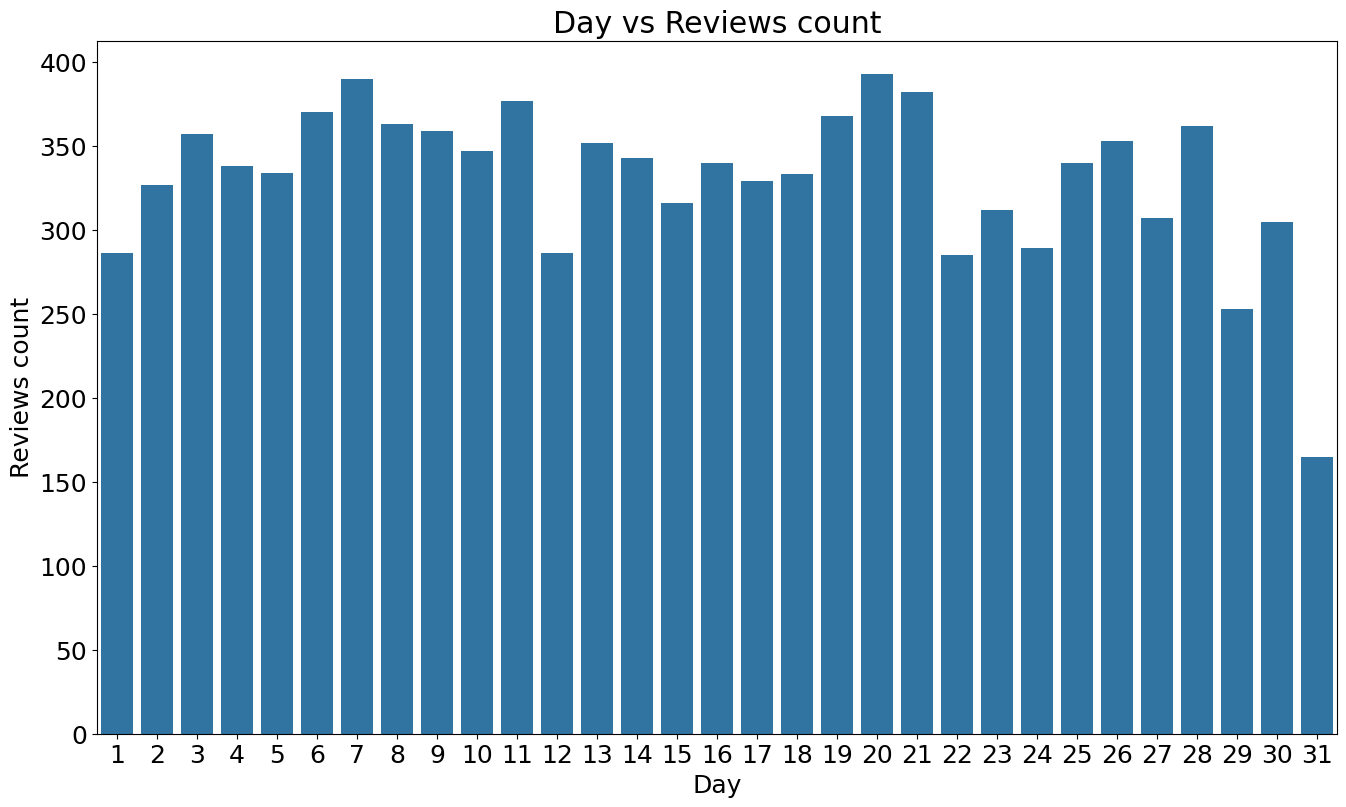

In [25]:
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

**The review counts are more or less uniformly distributed.There isn't much variance between the days. But there is a huge drop at the end of month. Our third assumption is wrong ! Never trust your instincts unles you do EDA.**

## Creating Additional Features for Text Analysis
**Now, let's generate a few features: polarity, review length, and word count**

- **Polarity:**  **Using TextBlob, we calculate the sentiment score, which ranges from -1 to 1, where -1 indicates negative polarity and 1 indicates positive polarity**
  
- **Review Length:** **This represents the total number of characters in the review, including letters and spaces**

- **Word Count:** **This indicates the total number of words in the review.**

In [26]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [27]:
process_reviews.head()

,reviewerID,asin,overall,reviews,sentiment,year,month,day,helpful_rate,polarity,review_len,word_count
0,A2IBPI20UZIR0U,1384719342,5,not much write but exactly supposed filters po...,Positive,2014,02,28,0.00,0.250000,162,25
1,A14VAT5EAX3D9S,1384719342,5,product exactly quite affordablei not realized...,Positive,2013,03,16,0.93,0.014286,356,55
2,A195EZSQDW3E21,1384719342,5,primary job device block breath would otherwis...,Positive,2013,08,28,1.00,0.167500,315,48
3,A2C00NNG1ZQQG2,1384719342,5,nice windscreen protects mxl mic prevents pops...,Positive,2014,02,14,0.00,0.333333,169,22
4,A94QU4C90B1AX,1384719342,5,pop filter great looks performs like studio fi...,Positive,2014,02,21,0.00,0.800000,136,21


In [28]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Sentiment polarity distribution
**looking at the polarity distribution**

In [29]:
process_reviews['polarity'].iplot(
    kind = 'hist',
    bins = 50,
    xTitle = 'polarity',
    linecolor = 'black',
    yTitle = 'count',
    title = 'Sentiment Polarity Distribution'
)

* **We have a lot of positive polarities compared to the negative polarities**
* **This polarity distributions assures the number of positive reviews we had**
* **We can say that this polarity is a normally distributed but not standard normal**


## Review Rating Distribution
**checking out how overall ratings are distributed**

In [30]:
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

There is a large number of 5 ratings(nearly 7k) followed by 4,3,2,1. It's linear in nature

## Review Text Length Distribution
**checking out the length of review text**

In [31]:
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

**there is a right skewed distribution where most of the lengths falls between 0-1000**

## Review Text Word Count Distribution
**checking out the word count of review text**

In [32]:
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

**there is a right skewed distribution with most of the words falling between 0-200 in a a review** 

## N-gram analysis
**Welcome to the deep text analysis. Here we will be using ngrams to analyse the text, based on it's sentiment **

## Monogram analysis
**most frequent plots will be here **one word in reviews** based on sentiments**

In [33]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

**As seen, the words doen't match with the sentiment except few. Through monogram we can't judge a sentiment based on one word. So let's try with frequent two words**

## Bigram analysis
**plotting of most frequent two words in reviews based on sentiments**

In [34]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

**Here we can get a clear idea about the sentiments from the bi-words**

## Trigram analysis
**plotting of the most frequent three words in reviews based on sentiments**

In [35]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')


text ngram analysis is now completed, let's look at wordcloud

## Wordcloud-Positive reviews

**displaying word cloud of positive reviews**

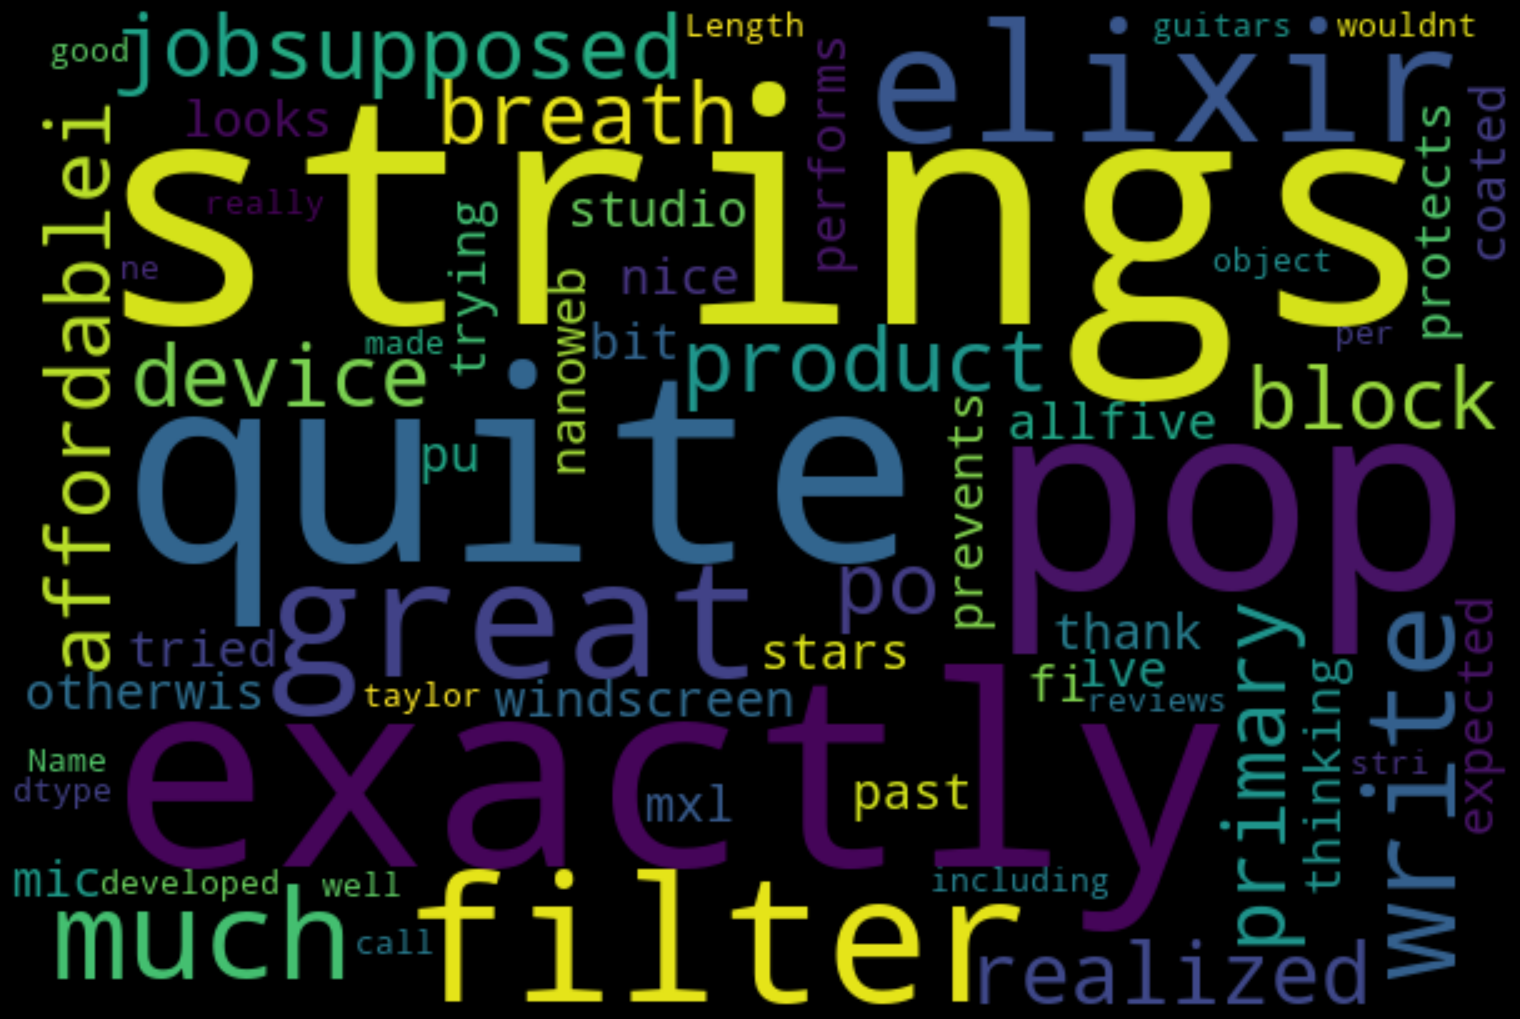

In [36]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 600,
    height = 400,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**We can see positive words like great,affordable,expected,exactly etc.,**

# Extracting Features from Cleaned Reviews
**Before building the sentiment analysis model, it's essential to transform the review texts into vector form, as computers cannot directly interpret words. The TF-IDF method will be used to perform this conversion.**

## Encoding target variable-sentiment
**encoding the target variable with Label encoder.**

In [37]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique() 

array([2, 1, 0])

In [38]:
process_reviews['sentiment'].value_counts()

sentiment
2    9022
1     772
0     467
Name: count, dtype: int64

## Stemming the reviews

In [39]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,not much write but exactly supposed filters po...
1,product exactly quite affordablei not realized...
2,primary job device block breath would otherwis...
3,nice windscreen protects mxl mic prevents pops...
4,pop filter great looks performs like studio fi...


In [40]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)    

In [41]:
corpus[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

**This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF**

## TFIDF(Term Frequency — Inverse Document Frequency)

**Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.**

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [43]:
X.shape

(10261, 5000)

**As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.**

In [44]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

## Handling Imbalance target feature-SMOTE
**In our target feature, we noticed that we got a lot of positive sentiments compared to negative and neutral. So it is crucial to balanced the classes in such situatio. Here I use SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem.It aims to balance class distribution by randomly increasing minority class examples by replicating them.** <br>

**SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.**

In [45]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


The resampled data has equally distributed classes

## Train-test split
**splitting the dataset into 75:25 ratio for train and test set respectively.**

In [46]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

<a id="section-five"></a>
# Model Building: Sentiment Analysis

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model selection

**Using all the classification algorithms and performing the model selection process**

In [48]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8811033859668104
Decision Tree Test Accuracy: 0.8127870118876114
KNN Test Accuracy: 0.8719417824014759
SVC Test Accuracy: 0.8795439317757772
Naive Bayes Test Accuracy: 0.8038184420263036


**Logistic regression has performed better than the rest of the algorithms and all the accuracies from the results are more than 80%. going with logistic regression and performing hyperparameter tuning on it.**

## Logistic Regression with Hyperparameter tuning
**using regularization parameter and penality for parameter tuning**

In [49]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9388207477464164


**From the selected params, we get accuracy. Let's plug and chug**

In [50]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


**We have got 94% accuracy. Getting a confusion matrix and checking f1 score rather than accuracy**

## Classification metrics
**plotting the confusion matrix with ROC and checking the f1 score**

In [51]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

Confusion matrix, without normalization


**Check out the diagonal elements(2326+2195+1854), they are correctly predicted records and rest are incorrectly classified by the algorithm**

In [52]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2326
           1       0.90      0.98      0.94      2232
           2       1.00      0.84      0.91      2209

    accuracy                           0.94      6767
   macro avg       0.94      0.94      0.94      6767
weighted avg       0.94      0.94      0.94      6767



## ROC-AUC curve
ROC is plotted for different classes which can help us understand which class was classified better.

Also, plotting micro and macro averages on the roc curve.

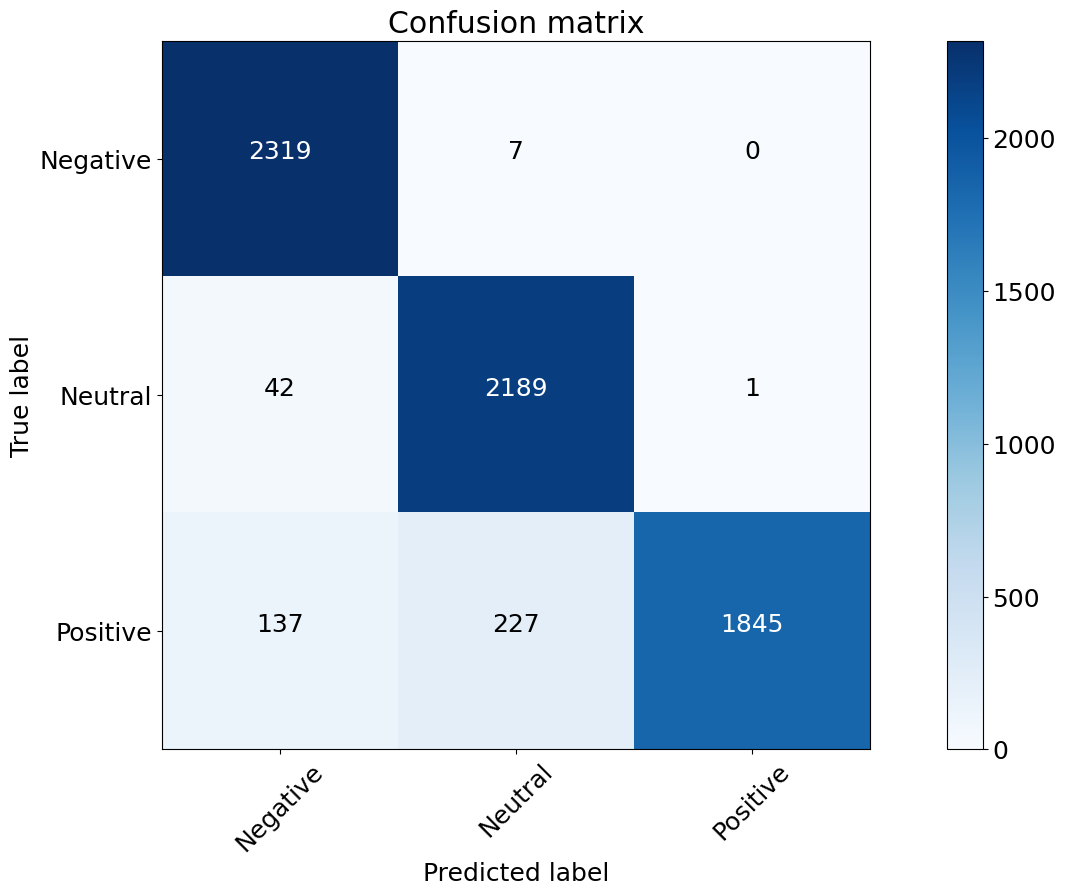

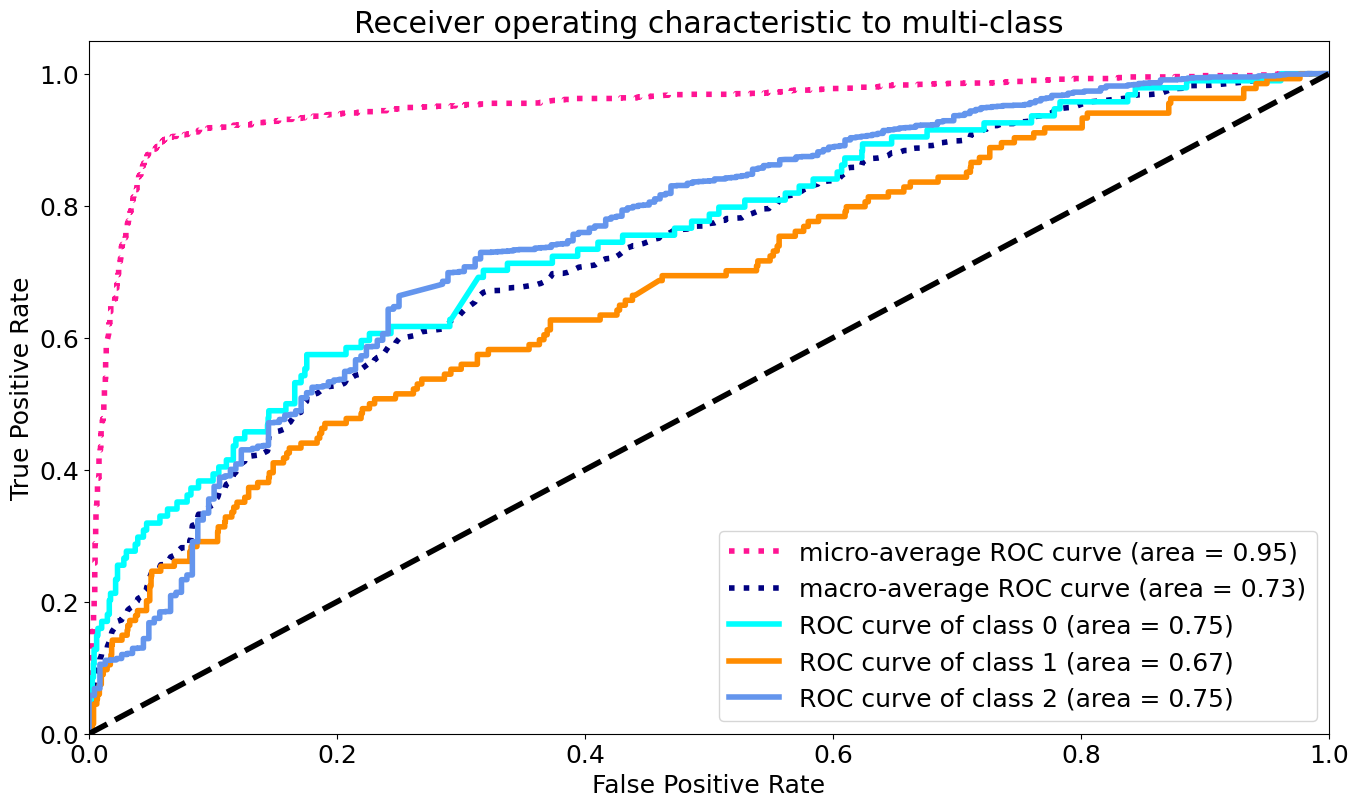

In [53]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Insights:

- Examining the ROC curve for the classes, classes 2 and 0 are well-classified, as their area under the curve (AUC) is high. An optimal threshold for balancing TPR and FPR would be in the range of 0.6–0.8.
- For the micro and macro averages, the micro-average performs significantly better, while the macro-average yields a comparatively lower score.
- If you're unsure about the difference between micro and macro averages, here's a simple explanation: 'A macro-average calculates the metric for each class independently and then averages them, treating all classes equally. On the other hand, a micro-average aggregates the metrics across all classes before calculating the average. In multi-class classification, micro-average is typically preferred when dealing with class imbalance.'

# Conclusion
We effectively classified all classes by splitting sentiments, cleaning text, customizing stopwords, and addressing imbalance with SMOTE.

## Key insights:

- N-grams are crucial for sentiment analysis, as single words lack context. Avoid using stopwords, as they can include negative terms.
- Neutral reviews often provide constructive feedback.
- Most reviews focused on string instruments, especially guitars.
- Balancing the dataset improved recall and F1 score, highlighting its importance.
- An F1 score of 94% reflects strong performance in this sentiment analysis.
